# Task 1---questions

**Q1**:
*When applied to a new, test instance the ensemble classifier aggregates the predictions of all predictors and estimates the statistical mode (i.e., return the most frequent prediction).*

*Is this similar to the hard or the soft voting strategy?*

**A**:
From the `scikit-learn` docs: 
```
    predict(self, X)

    Predict class for X.

    The predicted class of an input sample is computed as the class with the highest mean predicted
    probability. If base estimators do not implement a predict_proba method, then it resorts to voting.
```
Indeed, checking the source code for the `BaggingClassifier`'s `predict_proba` method confirms this. Therefore, the sklearn implementation prefers to do this the soft way, but will prefer hard voting over failure.


**Q2**:
*In light of your answer to Q1, will a `BaggingClassifier` perform soft or hard voting when based on `DecisionTreeClassifier`s?*
**A**:
The source code to `BaggingClassifier`'s `predict_proba` method performs the follwoing check, which returns `True` on a `DecisionTreeClassifier`.

```
    if hasattr(estimator, "predict_proba"):
     # perform soft voting
```

Thus the `BaggingClassifier` will perform soft voting in this case.

**Q3**:
*We said earlier than one of the advantages of bagging and pasting strategies is that predictors can all be trained in parallel. Is the same applicable to AdaBoost?*
**A**:
The reason that bagging classifiers may proceed with training in parallel is that their constituebt classifiers are independent of one another. This is not the case with boosting classifiers, so these cannot parallelise training.

**Q4**:
*Upon inspection of the `feature_importances` for the Iris data set in a random forest, we observe that the features pertaining to petals are assigned higher `feature_importance` values than those pertaining to the sepals, and that sepal width has a very low feature importance.*

*What do these results suggest? Are they similar to your observations from the previous experiments on this dataset?*

**A**:
These results suggest that the variance of sepal characteristics between the species is much smaller than that of petal characteristics.

This does conform with the results of practical 2. Recalling the scatter plot of sepal width against sepal length, we can make two observations: When comparing this plot with those scattering petal width against petal length, the instances of Setosa irides are have a lower average distance to the other samples in the data's projection onto this feature subspace than in others. Moreover, the samples of Versicolor and Virginica irides seem more 'interleaved' in that subspace. 

**Q6**:
*Another parameter to the `GradientBoostingRegressor` is `learning_rate`. What is it responsible for and what effect does it have on the resulting ensemble?*

**A**:
The learning rate is a measure of how much effect each iteration of the boosting has over the previous ensemble. Thus low learning rates will have the effect of requiring many estimators to achieve optimal performance, with a lower risk of overfitting the data or overshooting in the predictions. 


In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import pandas as pd

from tqdm import tqdm_notebook as tqdm

In [3]:
data_path = '../DSPNP_practical1/bike_sharing/bike_hour.csv'

bikes = pd.read_csv(data_path)
bikes = bikes.drop(['casual', 'registered', 'instant', 'dteday', 'season'], axis=1)

bikes.head()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## The Set-up

For this task, I will be using the BikeSharing data set from the optional task of practical 1.

For classification tasks, I shall be trying to classify the `workingday` feature, whereas for regression tasks, I shall be predicting the `num` feature. 

Let us begin with the binary classification of the `workingday` column. Since the ratio of working days against non-working days is quite skewed, we will have to stratify our training/test set split.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(test_size = 0.3, random_state=28)
for train_index, test_index in split.split(bikes, bikes['workingday']):
    strat_train_set = bikes.loc[train_index].drop('workingday', axis=1)
    strat_train_labels = bikes.loc[train_index]['workingday']
    strat_test_set = bikes.loc[test_index].drop('workingday', axis=1)
    strat_test_labels = bikes.loc[test_index]['workingday']

Let us quickly check the proportions of this split against a simple random split.

In [5]:
from sklearn.model_selection import train_test_split

rtrain, rtest = train_test_split(bikes, test_size=0.3, random_state=28)

In [6]:
def workingday_proportions(data):
    return data.sum() / len(data)

compare_props = pd.DataFrame({
    "Overall": workingday_proportions(bikes['workingday']),
    "Stratified tr": workingday_proportions(strat_train_labels),
    "Random tr": workingday_proportions(rtrain['workingday']),
    "Stratified ts": workingday_proportions(strat_test_labels),
    "Random ts": workingday_proportions(rtest['workingday']),
}, index=[0,1])

compare_props["Rand. tr %error"] = 100 * compare_props["Random tr"] / compare_props["Overall"] - 100
compare_props["Rand. ts %error"] = 100 * compare_props["Random ts"] / compare_props["Overall"] - 100
compare_props["Strat. tr %error"] = 100 * compare_props["Stratified tr"] / compare_props["Overall"] - 100
compare_props["Strat. ts %error"] = 100 * compare_props["Stratified ts"] / compare_props["Overall"] - 100

compare_props.sort_index()

,Overall,Stratified tr,Random tr,Stratified ts,Random ts,Rand. tr %error,Rand. ts %error,Strat. tr %error,Strat. ts %error
0,0.682721,0.682696,0.685656,0.682777,0.675873,0.429904,-1.003027,-0.003554,0.008292
1,0.682721,0.682696,0.685656,0.682777,0.675873,0.429904,-1.003027,-0.003554,0.008292


So our stratification was actually very helpful. Coolio, let's move on to more interesting things in life.

Let us begin with a simple voting classifier as in the practical. 

In [7]:
X_train = strat_train_set.values
y_train = strat_train_labels
X_test = strat_test_set.values
y_test = strat_test_labels

In [8]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier

log_clf = LogisticRegression(random_state=28)
sgd_clf = SGDClassifier(loss='perceptron', random_state=28)
svm_clf = SVC(probability=True, random_state=28)
gnb_clf = MultinomialNB()
ext_clf = ExtraTreeClassifier(criterion='entropy', random_state=28, max_depth=3)

clfs = [sgd_clf, svm_clf, log_clf, gnb_clf, ext_clf]

voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf), ('svm', svm_clf), ('ext', ext_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

/home/dks28/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='perceptron', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=28, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbo...
                                  verbose=False)),
                             ('ext',
                        

Let's see if these are somewhat variable in their classification---they *really* are!

In [9]:
import pandas as pd

def get_predictions(clf):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


preds = {'lr': get_predictions(log_clf), 
        'sgd': get_predictions(sgd_clf), 
        'svm': get_predictions(svm_clf),
        'gnb': get_predictions(gnb_clf),
        'ext': get_predictions(ext_clf)}
df = pd.DataFrame(data=preds)

df.corr()

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,lr,sgd,svm,gnb,ext
lr,1.000000,0.791732,0.017088,0.394080,1.000000
sgd,0.791732,1.000000,0.002060,0.307171,0.791732
svm,0.017088,0.002060,1.000000,0.083668,0.017088
gnb,0.394080,0.307171,0.083668,1.000000,0.394080
ext,1.000000,0.791732,0.017088,0.394080,1.000000


In [10]:
from sklearn.metrics import accuracy_score

for clf in clfs[0], clfs[1], clfs[-1] ,voting_clf:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SGDClassifier 0.7013808975834293


/home/dks28/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.883199079401611
ExtraTreeClassifier 0.7117376294591484


/home/dks28/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.7061756808592251


So, the performance of a voting classifier slghtly improves upon the individual performances of its constituents.

Let us see if we can further increase the accuracy by applying other ensemble methods, starting with bagging.

In [11]:
from sklearn.ensemble import BaggingClassifier

#use bootstrap=False for pasting
bag_clf = BaggingClassifier(
    ExtraTreeClassifier(random_state=28), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=28, oob_score=True)
# n_jobs = use all of the available CPU cores
bag_clf.fit(X_train, y_train)

bag_clf.oob_decision_function_

array([[0.11290323, 0.88709677],
       [0.5951417 , 0.4048583 ],
       [0.59959759, 0.40040241],
       ...,
       [0.12727273, 0.87272727],
       [0.6108871 , 0.3891129 ],
       [0.13253012, 0.86746988]])

In [12]:
[print(clf.__class__.__name__, accuracy_score(clf.predict(X_test), y_test)) for clf in (bag_clf, ext_clf)]

BaggingClassifier 1.0
ExtraTreeClassifier 0.7117376294591484


[None, None]

So Bagging does improve the performance of the classifier. Will pasting have a similar effect?

In [13]:
pas_clf = BaggingClassifier(
    ExtraTreeClassifier(random_state=28), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1, random_state=28)
# n_jobs = use all of the available CPU cores
pas_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=ExtraTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     random_state=28,
                                                     splitter='random'),
                  bootstrap=False, bootstrap_features=False, max_features=1.0,
                  max_samples=

In [14]:
[print(clf.__class__.__name__, accuracy_score(clf.predict(X_test), y_test)) for clf in (pas_clf, ext_clf)]

BaggingClassifier 1.0
ExtraTreeClassifier 0.7117376294591484


[None, None]

Let's see how sure the bagging classifier is with each of its perfect classifications.

(array([   3.,   12.,   83.,  142.,  288.,  481.,  689.,  761.,  693.,
         423.,  214.,   89.,   68.,  155.,  246.,  466.,  824., 1080.,
        1038., 1170., 1250., 1127.,  637.,  201.,   25.]),
 array([0.50404858, 0.52145256, 0.53885654, 0.55626052, 0.5736645 ,
        0.59106848, 0.60847246, 0.62587644, 0.64328042, 0.6606844 ,
        0.67808838, 0.69549236, 0.71289634, 0.73030032, 0.7477043 ,
        0.76510828, 0.78251226, 0.79991624, 0.81732022, 0.8347242 ,
        0.85212818, 0.86953215, 0.88693613, 0.90434011, 0.92174409,
        0.93914807]),
 <a list of 25 Patch objects>)

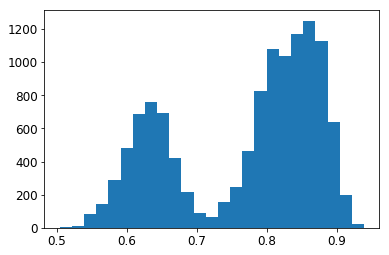

In [15]:
plt.hist(np.max(bag_clf.oob_decision_function_, axis=1), bins=25)

In [16]:
np.max(bag_clf.oob_decision_function_, axis=1)

array([0.88709677, 0.5951417 , 0.59959759, ..., 0.87272727, 0.6108871 ,
       0.86746988])

Let's also see how important each of the features in the data set is for this task.

In [17]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=28)

rnd_clf.fit(X_train, y_train)

for f, i in zip(bikes.drop(['workingday'], axis=1).columns, rnd_clf.feature_importances_):
    print(f, i)

yr 0.0024633332278832447
mnth 0.006128632592508981
hr 0.020319292964629445
holiday 0.08143113562903544
weekday 0.8366787877239502
weathersit 0.002234161780552275
temp 0.007420094130358104
atemp 0.007701677037008248
hum 0.009147911615471477
windspeed 0.005472192862560029
cnt 0.021002780436042534


As expected, the `weekday` feature (where $ \neg \mathtt{weekday} \implies \neg \mathtt{workingday}$) is the most important feature, with `holiday` having a similar implicative effect. 

This will be why the ensemble clssifiers do so well.

Before we move onto the regression task of predicting the number of bike rentals, let us quickly see whether adaptive boosting also performs so very well on this task.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=28)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [19]:
accuracy_score(y_test, ada_clf.predict(X_test))

1.0

In [20]:
ada_clf.estimator_errors_

array([1.70900123e-01, 5.60043661e-02, 1.72150028e-04, 6.52509266e-03,
       3.29536164e-03, 9.46411605e-05, 3.91602567e-03, 1.09097139e-03,
       1.24253190e-04, 3.60079780e-03, 6.12208497e-04, 1.91576668e-04,
       3.23799695e-03, 4.36228394e-04, 2.96448322e-04, 2.69372345e-03,
       3.63877552e-04, 4.37043239e-04, 2.11991342e-03, 3.41004346e-04,
       5.97720078e-04, 1.63578602e-03, 3.47423538e-04, 7.51785493e-04,
       1.27629129e-03, 3.73862213e-04, 8.73681221e-04, 1.02755908e-03,
       4.14826209e-04, 9.49499412e-04, 8.62326223e-04, 4.65812352e-04,
       9.79272839e-04, 7.55982828e-04, 5.22221061e-04, 9.72641745e-04,
       6.90331507e-04, 5.79235517e-04, 9.42714470e-04, 6.52806077e-04,
       6.32293244e-04, 9.01518278e-04, 6.34802258e-04, 6.77758110e-04,
       8.57932132e-04, 6.30274906e-04, 7.13424549e-04, 8.17471700e-04,
       6.34793723e-04, 7.38649711e-04, 7.82960164e-04, 6.44979284e-04,
       7.54121856e-04, 7.55391297e-04, 6.58199771e-04, 7.61414816e-04,
      

### OK, Let's move on to regression with gradient boosters.

As stated before, we will now consider the task of predicting the `cnt` column in the data set. Therefore, let's redefine the training and test sets:

In [21]:
reg_training, reg_test = train_test_split(bikes, test_size=0.2, random_state=28)

In [22]:
X_train_reg = reg_training.drop(['cnt'], axis=1).values
y_train_reg = reg_training['cnt']

X_test_reg = reg_test.drop(['cnt'], axis=1).values
y_test_reg = reg_test['cnt']

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=10, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
gbrt_slow = GradientBoostingRegressor(max_depth=10, n_estimators=300, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

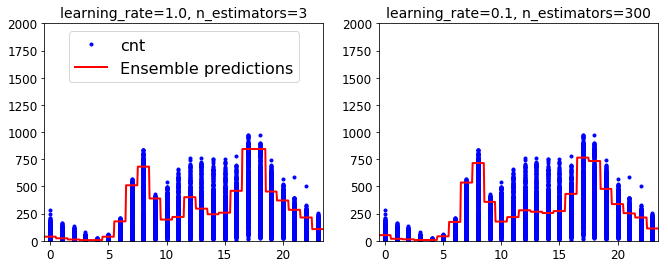

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None, column_index=2):
    x1 = np.linspace(axes[0], axes[1], 500)
    X_prime = np.matrix(np.ones(shape=(500, 1))) * np.matrix(np.mean(X, axis=0))
    X_prime[:, column_index] = x1.reshape(500,1)
    y_pred = sum(regressor.predict(X_prime) for regressor in regressors)
    plt.plot(X[:, column_index], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X_train_reg, y_train_reg, axes=[-0.5, 23.5, -0.1, 2000], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X_train_reg, y_train_reg, axes=[-0.5, 23.5, -0.1, 2000])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

The above lines do not seem very good. This is because all the features besides hr are set to their mean in the prediction of the `cnt` for the red line. Indeed, see the RMSE for these regressors:

In [26]:
from sklearn.metrics import mean_squared_error

bike_preds = [reg.predict(X_test_reg) for reg in (gbrt, gbrt_slow)]
fast_mse = mean_squared_error(y_test_reg, bike_preds[0])
fast_rmse = np.sqrt(fast_mse)
slow_mse = mean_squared_error(y_test_reg, bike_preds[1])
slow_rmse = np.sqrt(slow_mse)

In [27]:
print(fast_rmse, slow_rmse)

58.569874596628836 44.29386889417899


In [28]:
X_train_reg_n, X_val_reg, y_train_reg_n, y_val_reg = train_test_split(X_train_reg, y_train_reg, random_state=28)

gbrt = GradientBoostingRegressor(max_depth=10, n_estimators=500, random_state=42)
gbrt.fit(X_train_reg_n, y_train_reg_n)
errors = [mean_squared_error(y_val_reg, y_pred)
          for y_pred in gbrt.staged_predict(X_val_reg)]
bst_n_estimators = np.argmin(errors)
print(bst_n_estimators)
gbrt_best = GradientBoostingRegressor(max_depth=10,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train_reg, y_train_reg)

181


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=181,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

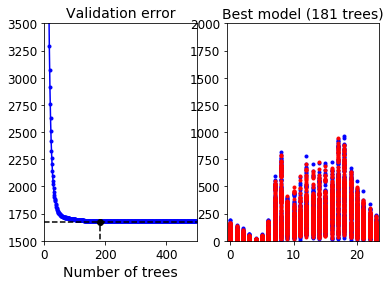

In [29]:
min_error = np.min(errors)

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 500], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.axis([0, 500, 1500, 3500])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

def plot_predictions_prime(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None, column_index=2):
    pred = regressors[0].predict(X)
    y_pred = sum(regressor.predict(X) for regressor in regressors)
    plt.plot(X[:, column_index], y, data_style, label=data_label)
    plt.plot(X[:, column_index], pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.subplot(122)
plot_predictions_prime([gbrt_best], X_test_reg, y_test_reg, axes=[-0.5, 23.5, -0.1, 2000], style='r.')
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [30]:
best_rmse = np.sqrt(mean_squared_error(gbrt_best.predict(X_test_reg), y_test_reg))
best_rmse

44.171047008694934

In [31]:
X_test_reg

array([[ 0.    ,  5.    , 16.    , ...,  0.697 ,  0.55  ,  0.3881],
       [ 1.    , 12.    , 13.    , ...,  0.3636,  0.42  ,  0.    ],
       [ 0.    ,  9.    , 12.    , ...,  0.6212,  0.69  ,  0.2239],
       ...,
       [ 0.    ,  8.    ,  9.    , ...,  0.6667,  0.74  ,  0.1642],
       [ 1.    ,  6.    , 13.    , ...,  0.6212,  0.41  ,  0.0896],
       [ 1.    ,  8.    , 21.    , ...,  0.6212,  0.54  ,  0.1045]])

# Task 3: Implementing a stacking algorithm.

In [32]:
def stack(original_regressors, combiner, X_train, y_train, X_test):
    X_trains, X_val, y_trains, y_val = train_test_split(X_train, y_train, random_state=28)
    for r in original_regressors:
        r.fit(X_trains, y_trains)
    validation_regressions = [r.predict(X_val) for r in original_regressors]
    X_val_prime = np.c_[X_val, np.transpose(validation_regressions)]
    combiner.fit(X_val_prime, y_val)
    test_regressions = [r.predict(X_test) for r in original_regressors]
    X_test_prime = np.c_[X_test, np.transpose(test_regressions)]
    return combiner.predict(X_test_prime)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


ln_reg = LinearRegression()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()



regs = [ln_reg, dt_reg, rf_reg]

for r in regs:
    r.fit(X_train_reg, y_train_reg)

rmses = [np.sqrt(mean_squared_error(y_test_reg, r.predict(X_test_reg))) for r in regs]
cmb_reg = GradientBoostingRegressor(max_depth=10, random_state=28, n_estimators=100)
preds = stack(regs, cmb_reg, X_train_reg, y_train_reg, X_test_reg)

/home/dks28/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
rmse_stack = np.sqrt(mean_squared_error(preds, y_test_reg))

In [35]:
for r, e in zip(regs + [cmb_reg], rmses+[rmse_stack]):
    print(r.__class__.__name__, e)

LinearRegression 141.35259713964427
DecisionTreeRegressor 59.77666768899049
RandomForestRegressor 48.758378239199196
GradientBoostingRegressor 50.93953070994868
